In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate


# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM
# plt.rcParams.update({'font.size': 6.7})  

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial',size=8)


In [2]:
exit_intensity_data = rf"./data/20251212_intensities_exit.h5"
data_intensities_exit =AM.read_hdf5_as_dict(exit_intensity_data)
data_intensities_exit.keys()
# data_field_intensities key containes the flux
            

dict_keys(['chi', 'data_field_intensities', 'data_field_intensities_2', 'f', 'sample', 'size', 'x'])

In [3]:
data_intensities_exit["data_field_intensities"].shape # (num_chi, num_size, sample, num_freq)

(13, 16, 5, 957, 150)

In [4]:
colors = [
          (1, 1, 1),  # White
          (0, 0, 1),  # Blue
          (1, 1, 0),  # Yellow
          (0, 1, 0),  # Green
          (1, 0, 0), #Red
          (0, 0, 0), # Black
          ]  

# Create a custom colormap
n_bins = 500  # Number of bins for smooth transition
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)

In [5]:
window = 5
def calculate_IPR(intensity_array,x1):
    values = intensity_array
    integral_1 = scipy.integrate.simpson(values**2, x=x1, axis=0)
    integral_2 = scipy.integrate.simpson(values, x=x1,axis=0)**2

    return integral_1/integral_2

def moving_average(x, w=window):
    return np.convolve(x, np.ones(w), 'valid') / w

def calculate_sigma(intensity_array, x1):
    x1 = np.asarray(x1)
    values = intensity_array

    # Reshape x1 to broadcast over columns (axis=1)
    x1 = x1[:, np.newaxis]  

    norm = scipy.integrate.trapezoid(values, x=x1[:, 0], axis=0)
    mean = scipy.integrate.trapezoid(values * x1, x=x1[:, 0], axis=0) / norm
    mean_sq = scipy.integrate.trapezoid(values * x1**2, x=x1[:, 0], axis=0) / norm
    sigma = np.sqrt(mean_sq - mean**2)
    return sigma


average_xis_exit = np.zeros(shape=(11,16,150-window+1)) #chi, size, freq
data_exit = np.copy(data_intensities_exit["data_field_intensities_2"])
for i,chi in enumerate(data_exit):
    if i in [0,12]:
        continue
    for j,length in enumerate(chi): 
        intensities =[]
        for k,sample in enumerate(length):
            # mask = sample/np.max(sample)>1e-9
            sample_normalized = sample/np.max(sample,axis=0)
            # sample_normalized[~mask]=0
            intensities.append(sample_normalized)

        average_intensity = np.mean(intensities,axis=0)
        average_xis_exit[i-1,j]=moving_average(calculate_IPR(average_intensity,data_intensities_exit["x"]))

average_xis_exit[np.isnan(average_xis_exit)] = 0
average_xis_exit[np.isinf(average_xis_exit)] = 0

In [6]:
#grab the bandgap data
gap_data_path = rf"H:\phd stuff\tidy3d\Notebooks\2D SHU Project\20250623 MPB Bands\20251215_Process_Bands\data\20251215_eps_11p56_chi_0p3_0p37_bgw_list.h5"
gap_data = AM.read_hdf5_as_dict(gap_data_path)
gap_data.keys()

dict_keys(['0.3', '0.31', '0.32', '0.33', '0.34', '0.35', '0.36', '0.37', '0.38', '0.39', '0.4'])

In [7]:
#Calculate average gap edges 
band_edge_array = np.array([np.mean([gap_data[str(chi)][str(sample)]["gap_edges"]
                    for sample in gap_data[str(chi)].keys()],
                    axis=0) for chi in gap_data.keys()]).squeeze()

band_edge_array.shape

(11, 2)

In [8]:
# #gap data from Luis 
# luis_gap_data_path = rf"H:\phd stuff\tidy3d\Notebooks\2D SHU Project\20250623 MPB Bands\Luis Data\band_structure_stats\20251218_bandgaps_chi_0p30_0p40_tolerance_0.02.h5"
# gap_data_luis = AM.read_hdf5_as_dict(luis_gap_data_path)

low_nDOS_boundaries=np.array([[0.297,0.297,0.299,0.303,0.308,0.315,0.323,0.333,0.338,0.343,0.354, 0.375, 0.380,0.380,0.384, 0.387, 0.390,0.394,0.398,0.401,0.404,0.407 ],
                         [0.40 , 0.39 , 0.38, 0.37,0.36,0.35,0.34,0.33,0.32,0.31, 0.30, 0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37, 0.38 , 0.39, 0.40]])

# PBG_boundaries=np.array([[0.297, 0.297 ,0.299, 0.3221,0.356,0.3679,0.3650,0.3659,0.3632,  0.3643, 0.3675,0.3677,0.3767,0.3833,0.3869, 0.401, 0.404, 0.407 ],
#                          [0.40 , 0.39 , 0.38, 0.37,0.36,0.35,0.34,0.33,0.32,0.32,0.33,0.34,0.35,0.36,0.37, 0.38 , 0.39, 0.40]])

PBG_boundaries=np.array([[0.297, 0.297 ,0.299, 0.3221,0.356,0.3679,0.3767,0.3833,0.3869, 0.401, 0.404, 0.407 ],
                         [0.40 , 0.39 , 0.38, 0.37,0.36,0.35,0.35,0.36,0.37, 0.38 , 0.39, 0.40]])

half = low_nDOS_boundaries[0].size // 2

band_edge_array =(np.c_[low_nDOS_boundaries[0, :half], low_nDOS_boundaries[0, :half-1:-1]])[::-1]

band_edge_array.shape

(11, 2)

In [9]:
size = 9

C:\Users\HernandF\AppData\Local\Temp\ipykernel_15756\1243925274.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_be_idx = np.arange(start_idx, np.shape(chi_new_values))
C:\Users\HernandF\AppData\Local\Temp\ipykernel_15756\1243925274.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(PBG_boundaries[0],PBG_boundaries[1],'k--',linewidth=1,color='#b63923')


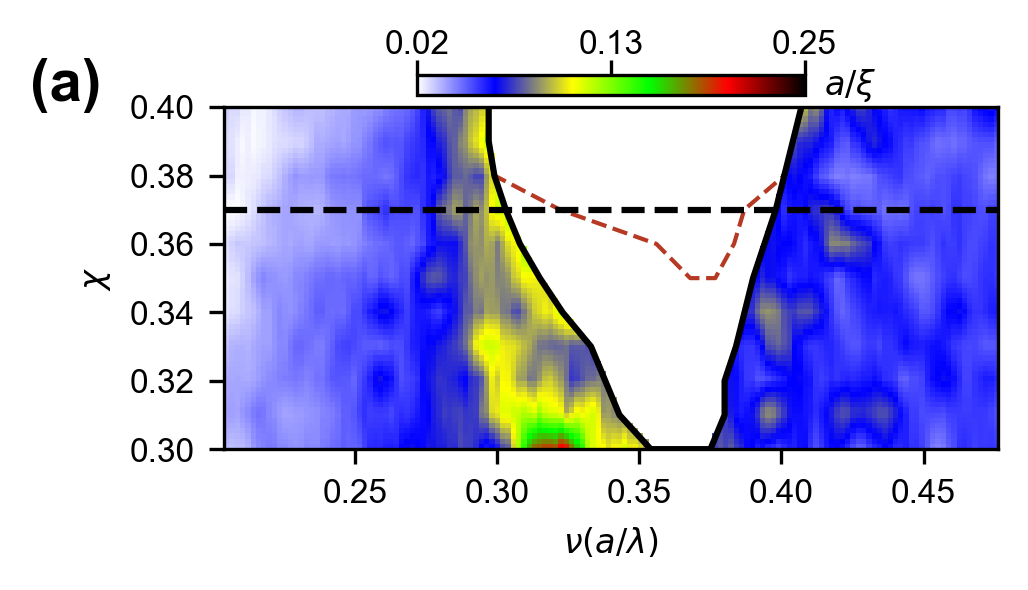

In [10]:
f = moving_average(data_intensities_exit["f"]/td.C_0)
k,l = 0,0
for h, length in enumerate(data_intensities_exit["size"]):
    if h not in [size]:
        continue
    fig, ax = plt.subplots(figsize=(3.5, 2), dpi=300)
    value = np.copy(average_xis_exit[:, h, :])

    n_interp = 6  # upsample factor in y
    chi_old = np.arange(value.shape[0])
    chi_new = np.linspace(0, chi_old[-1], value.shape[0] * n_interp)

    f_interp = interp1d(chi_old, value, axis=0, kind='linear')
    value_yinterp = f_interp(chi_new)
    value = value_yinterp

    # Build mask for bandgap region
    chi_vals = np.array(data_intensities_exit["chi"])[1:-1]
    n_chi, n_f = value.shape
    mask = np.zeros_like(value, dtype=bool)
    chi_new_values = np.linspace(0.3, 0.4, value.shape[0])

    start_idx_arr = np.flatnonzero(np.isclose(chi_new_values, 0.30))
    if start_idx_arr.size:
        start_idx = start_idx_arr[0]
    else:
        start_idx = np.searchsorted(chi_new_values, 0.30)
    
    end_idx_arr = np.flatnonzero(np.isclose(chi_new_values, 0.4))
    if end_idx_arr.size:
        end_idx = end_idx_arr[0]
    else:
        end_idx = np.searchsorted(chi_new_values, 0.4)
    
    chi_be_idx = np.arange(start_idx, np.shape(chi_new_values))
    be = np.asarray(band_edge_array)   # shape (9, 2)

    f_grid = f[None, :]                        # (1, n_f)

    # Interpolate band-edge frequencies to the chi grid used by `value`
    # chi_vals was defined above and aligns with rows of `be`
    # chi_target are the chi values corresponding to chi_be_idx
    chi_target = chi_new_values[chi_be_idx]
    f_low_orig = be[:, 0]
    f_high_orig = be[:, 1]
    interp_low = interp1d(chi_vals, f_low_orig, axis=0, bounds_error=False, fill_value='extrapolate')
    interp_high = interp1d(chi_vals, f_high_orig, axis=0, bounds_error=False, fill_value='extrapolate')
    f_low_interp = interp_low(chi_target)[:, None]   # (len(chi_be_idx), 1)
    f_high_interp = interp_high(chi_target)[:, None] # (len(chi_be_idx), 1)

    mask[chi_be_idx,:] = (f_grid >= f_low_interp) & (f_grid <= f_high_interp)
    
    value = np.ma.array(value, mask=mask)

    vmin = np.min(value)
    vmax = np.max(value)

    im=ax.imshow(value, vmin=vmin, vmax=0.25, 
                      extent =[np.min(f),np.max(f), 0.3,0.4], 
                         origin ='lower', cmap=cmap,
                         interpolation='nearest',   
                         aspect='auto') 
   
    ax.plot(PBG_boundaries[0],PBG_boundaries[1],'k--',linewidth=1,color='#b63923')
    ax.plot(low_nDOS_boundaries[0],low_nDOS_boundaries[1],'k-')
    ticks = np.linspace(vmin, 0.25, 3)
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.03, location="top", shrink=0.5, ticks=ticks)
    cbar.ax.set_xticklabels([f"{t:.2f}" for t in ticks])
    cbar.ax.text(1.05, 0.5, rf"$a/ \xi$", va='center', ha='left', transform=cbar.ax.transAxes)

    ax.axhline(0.37, linestyle='--', color="black", linewidth=1.5, alpha=1.0)
    cbar.ax.tick_params(labelsize=8,pad=0)
    cmap.set_bad(alpha=0.0)  # Set fully transparent for masked values
    ax.set_xlabel(rf"$\nu(a/\lambda)$")
    ax.set_ylabel(rf"$\chi$")
    ax.tick_params(axis='both', which='major')
    yticks = np.arange(0.3, 0.4, 0.02)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{t:.2f}" for t in yticks])
    ax.tick_params(axis='x', which='both', labelbottom=True)
    xticks = np.arange(0.25, 0.481, 0.05)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{t:.2f}" for t in xticks])
    ax.tick_params(axis='x', which='both', labelbottom=True)
    subplot_label = rf"({chr(97)})"  # chr(97) = 'a', chr(98) = 'b', etc.
    cbar.ax.text(-1, 0.5, subplot_label, transform=cbar.ax.transAxes,fontsize=14, fontweight='bold', va='center', ha='left')
    plt.tight_layout()
    # plt.savefig(rf'./figures/phase_diagram_{data_intensities_exit["chi"][8]:.2f}.pdf', bbox_inches='tight')
    plt.show()


In [11]:
#Loosy data 
ref = (1/average_xis_exit[8,size,:])
folder_str = "11_29_2024 Beam Spreading Freq Domain Lossy Background"
paths_loosy = []
L_abs = np.array([90,13,9,4,1,0.5])[::-1]
average_xis_exit_loosy = np.zeros(shape=(6,16,150-window+1))
for abs_length in L_abs:
    paths_loosy.append(rf"{folder_str}_{(abs_length)}")
for s,item in enumerate(paths_loosy):
    file = rf"F:\2D SHU Chi Statistics\data\{item}\intensities_exit.h5"
    with h5py.File(file, 'r') as h5f:
        data_intensities_exit_loosy = {
                "data_field_intensities": h5f["data_field_intensities"][:],
                "data_field_intensities_2": h5f["data_field_intensities_2"][:],
                "chi":np.array(h5f["chi"]),
                "size":np.array(h5f["size"]),
                "sample":np.array(h5f["sample"]),
                "x":np.array(h5f["x"]),
                "f":np.array(h5f["f"]),

            }
    f = data_intensities_exit_loosy["f"]/td.C_0
    data_exit_loosy = np.copy(data_intensities_exit_loosy["data_field_intensities_2"])
    for i,chi in enumerate(data_exit_loosy):
        if i not in [0]: #I only have one chi=0.37 for lossy sims
            continue
        for j,length in enumerate(chi): 
            intensities = []
            for k,sample in enumerate(length):
                # mask = sample/np.max(sample)>1e-9
                max_value = np.max(sample,axis=0)
                sample_normalized = sample/max_value
                # sample_normalized[~mask]=0   
                intensities.append(sample_normalized)

            average_intensity = np.mean(intensities,axis=0)
            average_xis_exit_loosy[s,j]=moving_average(calculate_IPR(average_intensity,data_intensities_exit_loosy["x"]))

    average_xis_exit_loosy[np.isnan(average_xis_exit_loosy)] = 0
    average_xis_exit_loosy[np.isinf(average_xis_exit_loosy)] = 0


C:\Users\HernandF\AppData\Local\Temp\ipykernel_15756\1772884814.py:32: RuntimeWarning: invalid value encountered in divide
  sample_normalized = sample/max_value


In [12]:
average_xis_exit_loosy.shape #L_abs, size, freq


(6, 16, 146)

In [13]:
average_xis_exit.shape #chi, size, freq

(11, 16, 146)

In [14]:
#Open data from wavefunctions
import csv
file_wavefunctions = rf".\data\IPR_wavefunctions_chi_0.37_xi_means.csv"
freqs_wavefunctions = []
ipr_wavefunctions = []
with open(file_wavefunctions, newline='') as csvfile: 
                reader = csv.reader(csvfile)
                for row in reader:
                    try:
                        freqs_wavefunctions.append(float(row[0]))
                        ipr_wavefunctions.append(float(row[1])) 
                    except ValueError:
                        print(row)
                        continue


freqs_wavefunctions = np.array(freqs_wavefunctions)
ipr_wavefunctions = np.array(ipr_wavefunctions) 

mask_freqs_wavefunctions = (np.array(freqs_wavefunctions)>=0.2) & (np.array(freqs_wavefunctions)<=0.48)


['freq', 'xi_mean', 'xi_harmonic_mean', 'xi_mi', 'xi_max']


C:\Users\HernandF\AppData\Local\Temp\ipykernel_15756\2185887117.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=10)
C:\Users\HernandF\AppData\Local\Temp\ipykernel_15756\2185887117.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=10)


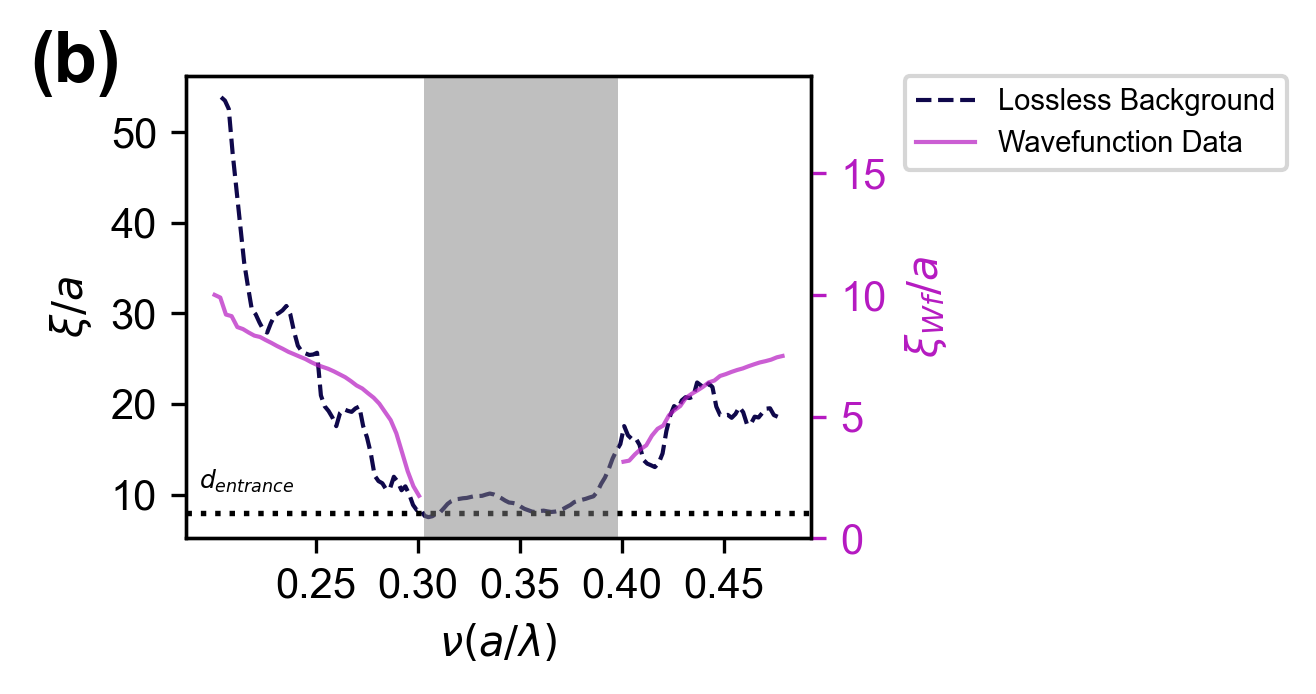

In [15]:
gap_limit = band_edge_array[7]  # for chi=0.37

mask_gap_wavefunctions = (freqs_wavefunctions>=gap_limit[0]) & (freqs_wavefunctions<=gap_limit[1])
ipr_wavefunctions[mask_gap_wavefunctions]=np.nan

fig, ax = plt.subplots(figsize=(3.5, 2), dpi=300)
value = np.copy(average_xis_exit[7,size,:])

ax2 = ax.twinx()
ax2.plot(freqs_wavefunctions[mask_freqs_wavefunctions], ipr_wavefunctions[mask_freqs_wavefunctions],
         linewidth=1, label="Wavefunction Data", color="#b51ac1", alpha=0.7)
# style right axis
ax2.tick_params(axis='y', colors='#b51ac1')
ax2.set_ylim(0,19)
ax2.set_ylabel(rf"$\xi_{{Wf}}/a$", color='#b51ac1', fontsize=10)
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=10)
# original left-axis plot remains
ax.plot(moving_average(f),(1/value),"--", linewidth=1,label=rf"Lossless Background",color="#0f084b")
# combine legends from both axes
lines2, labels2 = ax2.get_legend_handles_labels()
lines, labels = ax.get_legend_handles_labels()
ax.axvspan(gap_limit[0], gap_limit[1], facecolor='gray', alpha=0.5, edgecolor='none', zorder=1000, clip_on=False)
ax.set_xlabel(rf"$\nu(a/\lambda)$",fontsize=10)
ax.set_ylabel(rf"$\xi/a$",fontsize=10)
fig.subplots_adjust(right=0.72)  # leave space for the legend

# Set x-ticks to match the phase-diagram plot (0.25 to 0.48 step 0.05)
xticks = np.arange(0.25, 0.481, 0.05)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{t:.2f}" for t in xticks],fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=10)
ax.tick_params(axis='x', which='both', labelbottom=True)

ax.axhline(8, linestyle=':', color="black", linewidth=1.3, alpha=1.0)
ax.annotate(rf"$d_{{entrance}}$", xy=(0.02, 10), xycoords=('axes fraction','data'),
                                  color="black", fontsize=6, va='bottom', ha='left')
ax.legend(lines+lines2, labels+labels2, loc='upper left', bbox_to_anchor=(1.15, 1), borderaxespad=0., fontsize=7)
subplot_label = rf"({chr(98)})"  # chr(97) = 'a', chr(98) = 'b', etc.
ax.text(-0.25, 1.1, subplot_label, transform=ax.transAxes,fontsize=17, fontweight='bold', va='top', ha='left')
# plt.savefig(rf'./figures/xi_{data_intensities_exit["chi"][7+1]:.2f}_lossless_wavefunction_size_{size}.pdf', bbox_inches='tight')
plt.show()


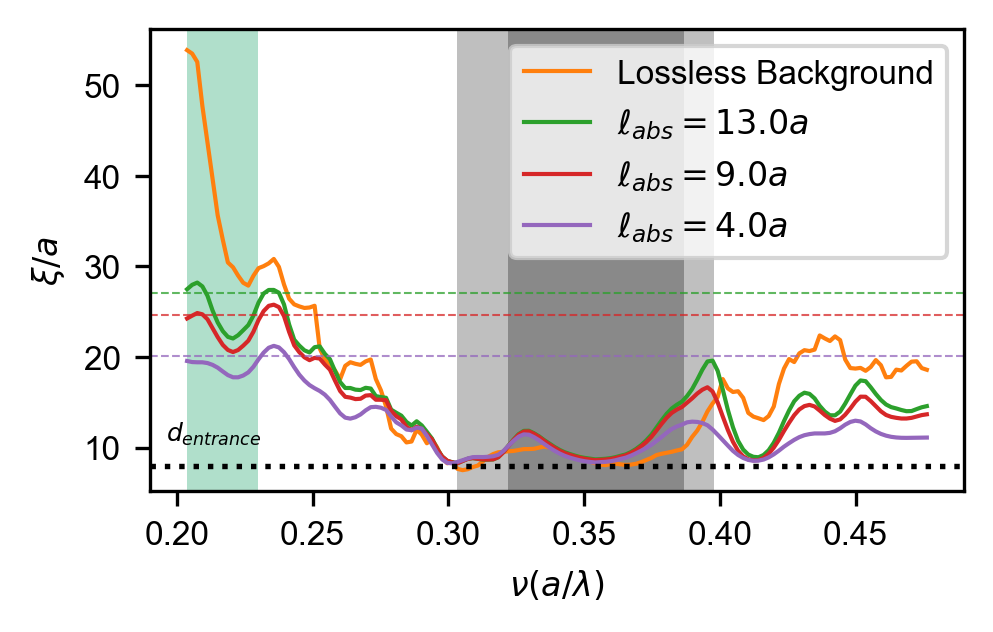

In [18]:
import matplotlib as mpl
from cycler import cycler

palette = ["#FF7F0E","#2CA02C","#D62728","#9467BD","#8C564B","#7F7F7F"]

mpl.rcParams['axes.prop_cycle'] = cycler('color', palette)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 8

gap_limit = band_edge_array[7]  # for chi=0.37

mask_gap_wavefunctions = (freqs_wavefunctions>=gap_limit[0]) & (freqs_wavefunctions<=gap_limit[1])

lt=0.65


half_pbg = PBG_boundaries[0].size // 2

pbg_array =(np.c_[PBG_boundaries[0, :half_pbg], PBG_boundaries[0, :half_pbg-1:-1]])[::-1]
gap_limit_pbg = pbg_array[2]  # for chi=0.37



ipr_wavefunctions[mask_gap_wavefunctions]=np.nan



fig, ax = plt.subplots(figsize=(3.5,2),dpi=300)
value = np.copy(average_xis_exit[7,size,:])
ax.axvspan(gap_limit[0], gap_limit[1], facecolor='gray', alpha=0.5, edgecolor='none', zorder=-1, clip_on=False)
ax.axvspan(gap_limit_pbg[0], gap_limit_pbg[1], facecolor='gray', alpha=0.85, edgecolor='none', zorder=-1, clip_on=False)
ax.axvspan(np.min(moving_average(f)),0.23, facecolor='#3aaf7d', alpha=0.4, edgecolor='none', zorder=-1, clip_on=False)
# original left-axis plot remains
ax.plot(moving_average(f),(1/value), linewidth=1,label=rf"Lossless Background")
# combine legends from both axes
for h in reversed(range(2, 5)):
    label_la = L_abs[h] 
    La = np.sqrt(label_la*lt/2)
    saturation_abs = 2*np.pi*np.sqrt(9*La)
    ax.axhline(saturation_abs, linestyle='--', color=palette[-h-1], linewidth=0.5, alpha=0.75)
    ax.plot(moving_average(f),(1/average_xis_exit_loosy[h,size,:]), linewidth=1,label=rf"$ \ell_{{abs}}={label_la}{"a" if label_la != r"\text{Lossless Background}" else ""}$")

lines, labels = ax.get_legend_handles_labels()

plt.xlabel(rf"$\nu(a/\lambda)$")
ax.set_ylabel(rf"$\xi/a$")
# fig.subplots_adjust(right=0.72)  # leave space for the legend
ax.axhline(8, linestyle=':', color="black", linewidth=1.3, alpha=1.0)
ax.annotate(rf"$d_{{entrance}}$", xy=(0.02, 10), xycoords=('axes fraction','data'),
                                  color="black", fontsize=6, va='bottom', ha='left')
# ax.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=6)
ax.legend()
subplot_label = rf"({chr(98)})"  # chr(97) = 'a', chr(98) = 'b', etc.
plt.savefig(rf'./figures/xi_{data_intensities_exit["chi"][7+1]:.2f}_abs_size_{size}.pdf', bbox_inches='tight')
plt.show()

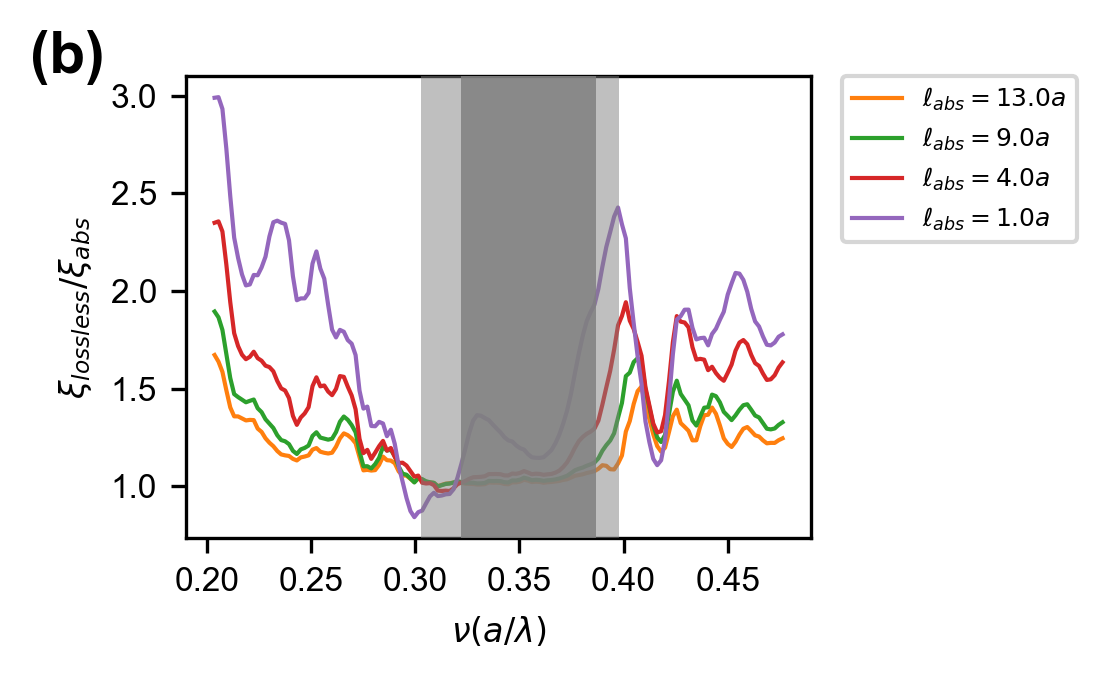

In [17]:
#plto ratio of the abs curves to the lossless curve
fig, ax = plt.subplots(figsize=(3.5,2),dpi=300)
for h in reversed(range(1, 5)):
    label_la = L_abs[h] if L_abs[h]!= 90 else r"\text{Lossless Background}"
    ratio = (1/average_xis_exit_loosy[5,size,:])/(1/average_xis_exit_loosy[h,size,:])
    ax.plot(moving_average(f),ratio, linewidth=1,label=rf"$ \ell_{{abs}}={label_la}{"a" if label_la != r"\text{Lossless Background}" else ""}$")
lines, labels = ax.get_legend_handles_labels()
ax.axvspan(gap_limit[0], gap_limit[1], facecolor='gray', alpha=0.5, edgecolor='none', zorder=1000, clip_on=False)
ax.axvspan(gap_limit_pbg[0], gap_limit_pbg[1], facecolor='gray', alpha=0.85, edgecolor='none', zorder=1000, clip_on=False)
plt.xlabel(rf"$\nu(a/\lambda)$")
ax.set_ylabel(rf"$\xi_{{lossless}}/\xi_{{abs}}$")
fig.subplots_adjust(right=0.72)  # leave space for the legend
ax.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=6)
subplot_label = rf"({chr(98)})"  # chr(97) = 'a', chr(98) = 'b', etc.
ax.text(-0.25, 1.1, subplot_label, transform=ax.transAxes,fontsize=14, fontweight='bold', va='top', ha='left')
# plt.savefig(rf'./figures/xi_ratio_{data_intensities_exit["chi"][7+1]:.2f}_abs_size_{size}.pdf', bbox_inches='tight')
plt.show()